In [1]:
import os
import operator

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
TRAIN_PATH = '../input/train'
TRAIN_FULL_PATH = '/kaggle2/hpaic/train-full'

TEST_PATH = '../input/test'
TEST_FULL_PATH = '/kaggle2/hpaic/test-full'

In [2]:
def _load_512_green(image_id):
    base_path = TRAIN_PATH    
    img = None
    flags = cv2.IMREAD_GRAYSCALE
    path = os.path.join(base_path, f"{image_id}_green.png")
    img_ = cv2.imread(str(path), flags).astype(np.float32) / 255.
    return img_

def build_candidates(train_ids):    
    candidates = []    
    
    for image_id in tqdm(train_ids):
        # load 512 image, find candidate patches
        img = _load_512_green(image_id)
        total = np.sum(img) 
        
        size = 512
        patch_size = 96 # 512/6 -- 512/4
        stride = 32
        
        max_patches = 100 # maximum patches per image        
        patches = {}
        for j in range(0, size - patch_size, stride):
            for i in range(0, size - patch_size, stride):
                s = np.sum(img[j:j+patch_size, i:i+patch_size])                
                if s > 0:
                    patches[(j, i)] = s 
        
        # order patches by sum of pixels
        for patch, s in sorted(patches.items(), key=operator.itemgetter(1), reverse=True)[:max_patches]:
            patch_j, patch_i = patch
            if s > 0:
                candidates.append((image_id, patch_j, patch_i))
        
    return candidates

def build_sample():
    IMAGES_PER_CLASS = 100 # TODO: remove this later
    
    df = pd.read_csv('../input/train.csv')
    
    train_ids = []
    
    for klazz in range(28):
        klazz_df = df[df.Target==str(klazz)]
        sample_size = min(IMAGES_PER_CLASS, len(klazz_df))        
        # print(klazz, sample_size)
        if sample_size > 0:
            train_ids.extend(klazz_df.sample(n=sample_size).Id.values)  
        
    return train_ids


image_ids = build_sample()
patch_ids = build_candidates(image_ids)

100%|██████████| 2174/2174 [00:13<00:00, 161.03it/s]


In [3]:
from sklearn.model_selection import StratifiedKFold

# build fold.csv having patch_ids for single-class samples
def build_folds(patch_ids):
    df = pd.read_csv('../input/train.csv')
    labels = df.set_index('Id').to_dict()['Target']
    rows = []
    for image_id, patch_j, patch_i in patch_ids:
        label = labels[image_id]
        rows.append([image_id, patch_j, patch_i, label])
        
    df2 = pd.DataFrame(rows, columns=['image_id', 'patch_j', 'patch_i', 'target'])
    df2['fold'] = 0
    n_fold = 5
    skf = StratifiedKFold(n_splits=n_fold, random_state=123, shuffle=True)
    for fold_no, (train_idx, test_idx) in enumerate(skf.split(range(len(rows)), df2.target)):
        df2.loc[test_idx, 'fold'] = fold_no    
        
    df2['idx'] = range(len(df2))
    df2.to_csv(os.path.join('../data/singleclasspatchesfolds.csv'), index=False)

# generate singleclasspatchesfolds.csv    
build_folds(patch_ids)

In [7]:
def _load_patch_from_png(image_id, patch_j, patch_i, patch_size, mode='train'):
    base_path = TEST_PATH if mode == 'test' else TRAIN_PATH
    kinds = ['red', 'blue', 'yellow', 'green']
    img = None
    flags = cv2.IMREAD_GRAYSCALE
    img = np.zeros((patch_size, patch_size, len(kinds)), np.float32)
    for idx, kind in enumerate(kinds):
        path = os.path.join(base_path, f"{image_id}_{kind}.png")
        img_ = cv2.imread(str(path), flags).astype(np.float32) / 255.
        img[:, :, idx] = img_[patch_j:patch_j+patch_size, patch_i:patch_i+patch_size]        
    return img

def _load_tif(image_id, mode='train'):
    base_path = TEST_FULL_PATH if mode == 'test' else TRAIN_FULL_PATH
    kinds = ['red', 'blue', 'yellow', 'green']
    img = None
    flags = cv2.IMREAD_GRAYSCALE
    img = None
    for idx, kind in enumerate(kinds):
        path = os.path.join(base_path, f"{image_id}_{kind}.tif")
        img_ = cv2.imread(str(path), flags).astype(np.float32) / 255.
        if img is None:
            # we don't know original size, could be 512, or resized during preprocessing to a smaler size.
            original_size = img_.shape[0]
            img = np.zeros((original_size, original_size, len(kinds)), np.float32)
        img[:, :, idx] = img_
    return img

def _load_patch_from_tif(tiff_img, patch_j, patch_i, patch_size, size):
    """ load patch from tiff given patch coordinates. coordinates are given wrt png file.
    """            
    img_size_ = tiff_img.shape[0]
    factor = img_size_ / 512.
    patch_j_ = int(patch_j * factor)
    patch_i_ = int(patch_i * factor)
    patch_size_ = int(patch_size * factor)
    return cv2.resize(tiff_img[patch_j_:patch_j_+patch_size_, patch_i_:patch_i_+patch_size_, :], (size, size))    
    
import h5py
def save_patches():
    df = pd.read_csv('../data/singleclasspatchesfolds.csv')
    
    patch_size = 96
    size = 224
    out_path = f'/kaggle2/hpaic-cache'
    os.makedirs(out_path, exist_ok=True)
    f = h5py.File(os.path.join(out_path, f'train_{patch_size}.h5'), 'w')
    imgs = f.create_dataset('train', (len(df), size, size, 4), dtype=np.uint8)
    
    for image_id, patches in tqdm(df[['idx', 'image_id', 'patch_j', 'patch_i']].groupby('image_id')):
        tiff_img = _load_tif(image_id)
        for idx, patch_j, patch_i in patches[['idx', 'patch_j', 'patch_i']].values:
            patch = _load_patch_from_tif(tiff_img, patch_j, patch_i, patch_size, size)
            imgs[idx] = patch * 255
    f.close()

In [ ]:
save_patches()


  0%|          | 10/2174 [00:02<09:31,  3.78it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/miniconda2/envs/hpaic/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/miniconda2/envs/hpaic/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/miniconda2/envs/hpaic/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|█████████▉| 2166/2174 [25:30<00:05,  1.42it/s]

In [60]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import random

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [ ]:
x = [transforms.ToTensor()(load_patch_from_png(image_id, patch_j, patch_i, 96)[:, :, :3]) for image_id, patch_j, patch_i in patches]
x2 = [transforms.ToTensor()(load_patch_from_tif(image_id, patch_j, patch_i, 96, 224)[:, :, :3]) for image_id, patch_j, patch_i in patches]

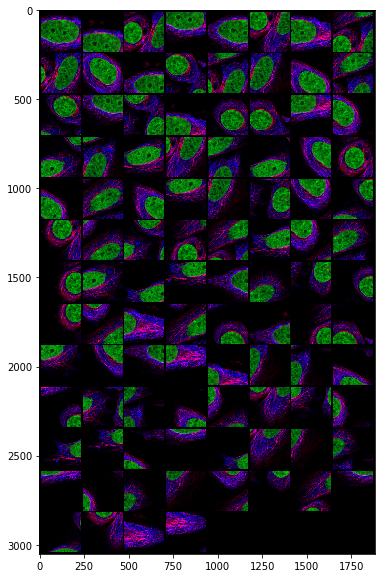

In [57]:
plt.figure(figsize=(10, 10))
show(make_grid(x2, padding=10))

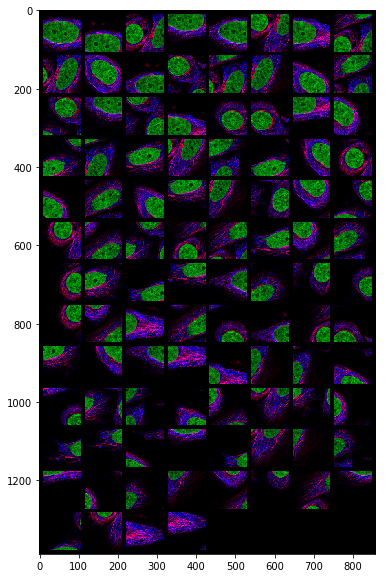

In [59]:
plt.figure(figsize=(10, 10))
show(make_grid(x, padding=10))

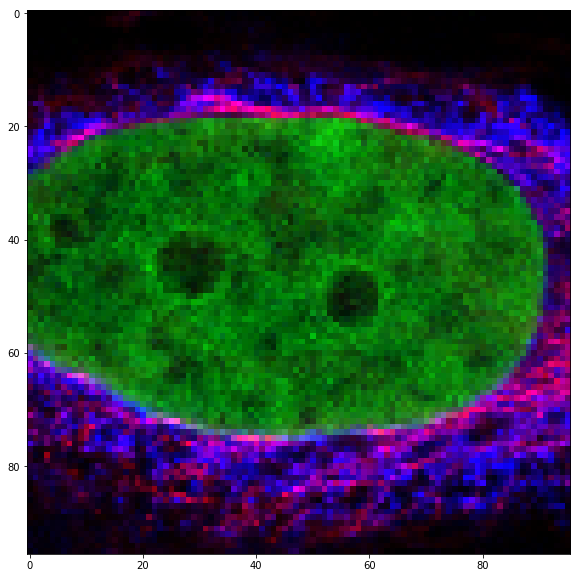

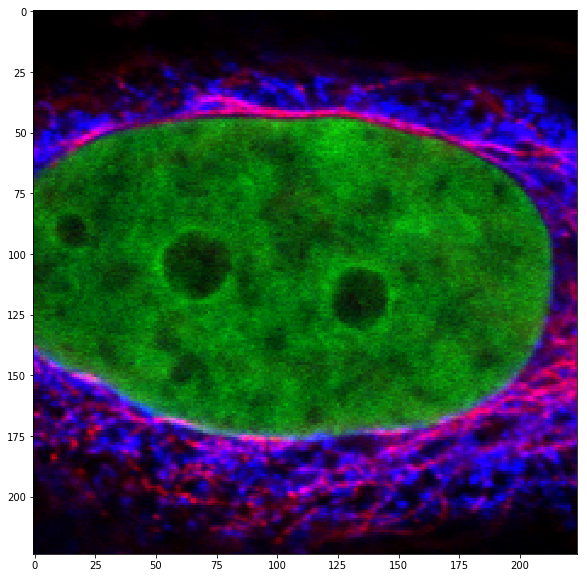

In [66]:
image_id, patch_j, patch_i = patches[0]

plt.figure(figsize=(10, 10))
plt.imshow(load_patch_from_png(image_id, patch_j, patch_i, 96)[:,:,:3])

plt.figure(figsize=(10, 10))
plt.imshow(load_patch_from_tif(image_id, patch_j, patch_i, 96, 224)[:,:,:3])